In [82]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator
from qiskit.transpiler.passes import RemoveFinalMeasurements

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [83]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

## Build a tiled pool

In [84]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 31]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]

Current energy: -6.000000000000006
(change of -1.7639320225002075)
Current ansatz: [244, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.000000000000006)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 210]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752619964306
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071047541058)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 210, 225]...
Starting point: [np.float64(0.7853981908695737), np.float64(0.7853981903042655), np.float64(0.1224892

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000019367)]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 228]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.123105625562482
(change of -0.1231056256329639)
Current ansatz: [228, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201775814
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710484682814)]
Initial energy: -6.123105625562482
Optimizing energy with indices [228, 79, 228, 210]...
Starting point: [np.float64(-0.7853947065772693), np.float64(0.7853985308794288), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929516
(change of -1.7639320224297173)
Current ansatz: [225, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647983
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000019367)]
Initial energy: -5.999999999929516
Optimizing energy with indices [225, 31, 228]...
Starting point: [np.float64(0.7853947065773541), np.float64(-0.7853993777262479), np.float64(0.0)]

Current energy: -6.123105625562488
(change of -0.1231056256329719)
Current ansatz: [225, 31, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201775825
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071048468285)]
Initial energy: -6.123105625562488
Optimizing energy with indices [225, 31, 228, 210]...
Starting point: [np.float64(0.7853947065772433), np.float64(-0.7853985308794607), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.999999999994421)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 225]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610644
(change of -0.12310562561245586)
Current ansatz: [225, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955813
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850687898689876)]
Initial energy: -6.123105625610644
Optimizing energy with indices [225, 79, 225, 198]...
Starting point: [np.float64(0.7853983869831812), np.float64(0.7853991695302517), np.float64(-0.12248869758311735), np.float64(0.0)]

Current energy: -6.327276154816648
(change of -0.20417052920600387)
Current ansatz: [225, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819971
(change of -0.2041705292023286)
Current ansatz: [241, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964057733311
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.089491629507777)]
Initial energy: -6.327276154819971
Optimizing energy with indices [241, 74, 228, 210, 57]...
Starting point: [np.float64(-0.785398162447052), np.float64(-0.7853981711958521), np.float64(0.16357028748210503), np.float64(0.16356997569593643), np.float64(0.0)]

Current energy: -6.464101615067938
(change of -0.13682546024796682)
Current ansatz: [241, 74, 228, 210, 57]
Performing final convergence check...
Total gradient norm: 0.00013840069558915347

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964057733311 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list o

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917506431664028
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.485060029388178)]
Initial energy: -6.123105625548022
Optimizing energy with indices [228, 26, 201, 228]...
Starting point: [np.float64(-0.7853977521552514), np.float64(0.7853977933764661), np.float64(0.12248644006210563), np.float64(0.0)]

Current energy: -6.327276154816646
(change of -0.204170529268624)
Current ansatz: [228, 26, 201, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962578717635
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.0894929267475435)]
Initial energy: -6.327276154816646
Optimizing energy with indices [228, 26, 201, 228, 216]...
Starting point: [np.float64(-0.7853977521552578), np.float64(0.785398879885591), np.float64(0.16357019699115474), np.float64(0.16356963656316748), np.float64(0.0)]

Current energy: -6.464101615068982
(change of -0.13682546025233577)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013734916060266638

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962578717635 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 31]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929516
(change of -1.7639320224297173)
Current ansatz: [225, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647983
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.000000000019367)]
Initial energy: -5.999999999929516
Optimizing energy with indices [225, 31, 225]...
Starting point: [np.float64(0.7853947065773541), np.float64(-0.7853993777262479), np.float64(0.0)]

Current energy: -6.123105625562486
(change of -0.12310562563297012)
Current ansatz: [225, 31, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201775823
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.4850710484412666)]
Initial energy: -6.123105625562486
Optimizing energy with indices [225, 31, 225, 45]...
Starting point: [np.float64(0.7853947065772626), np.float64(-0.7853985308794541), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.424965606542188e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531963 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [225]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [225]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [225]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [225, 26]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955772
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485068789868967)]
Initial energy: -6.123105625610641
Optimizing energy with indices [225, 26, 228, 210]...
Starting point: [np.float64(0.7853983869831882), np.float64(0.7853991695302422), np.float64(0.12248869758311211), np.float64(0.0)]

Current energy: -6.327276154816647
(change of -0.20417052920600565)
Current ansatz: [225, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964056416012
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916407310475)]
Initial energy: -6.327276154816647
Optimizing energy with indices [225, 26, 228, 210, 147]...
Starting point: [np.float64(0.7853984379184572), np.float64(0.7853991591701212), np.float64(0.16357028929940762), np.float64(0.16356997348722374), np.float64(0.0)]

Current energy: -6.464101615069497
(change of -0.13682546025285003)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474305875)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 198]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.32727615482008
(change of -0.20417052920242895)
Current ansatz: [244, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963610610418
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894920221535056)]
Initial energy: -6.32727615482008
Optimizing energy with indices [244, 79, 225, 198, 210]...
Starting point: [np.float64(0.7853981493735948), np.float64(0.7853981777037257), np.float64(-0.16357026021874255), np.float64(-0.16356987308330864), np.float64(0.0)]

Current energy: -6.464101615050827
(change of -0.13682546023074682)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00014811055823501704

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963610610418 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000018)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154819709
(change of -0.20417052920205858)
Current ansatz: [244, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580530028
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089492926737891)]
Initial energy: -6.327276154819709
Optimizing energy with indices [244, 79, 225, 210, 198]...
Starting point: [np.float64(0.7853981700346647

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999417229
(change of -1.3737154597822618)
Current ansatz: [211, 244, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958970181085
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.9999999998057472)]
Initial energy: -5.999999999417229
Optimizing energy with indices [211, 244, 79, 228]...
Starting point: [np.float64(-9.855379305101342e-06), np.float64(0.7853981714334987), np.float64(0.7853981407341446), np.float64(0.0)]

Current energy: -6.123105625041492
(change of -0.1231056256242633)
Current ansatz: [211, 244, 79, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620050184
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710482493232)]
Initial energy: -6.123105625041492
Optimizing energy with indices [211, 244, 79, 228, 210]...
Starting point: [np.float64(-9.693301808235

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000018)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617655
(change of -0.12310562561764904)
Current ansatz: [244, 31, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620132718
Operator(s) added to ansatz: [180]
Gradients: [np.float64(2.485071048479707)]
Initial energy: -6.123105625617655
Optimizing energy with indices [244, 31, 216, 180]...
Starting point: [np.float64(0.7853981646238432), np.float64(-0.7853981621539974), np.float64(-0.1224892796141143), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548199945
(change of -0.20417052920233925)
Current ansatz: [244, 31, 216, 180]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041689943
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.0894916435963014)]
Initial energy: -6.3272761548199945
Optimizing energy with indices [244, 31, 216, 180, 201]...
Starting point: [np.float64(0.7853981625535668), np.float64(-0.7853981690429753), np.float64(-0.16357028650384128), np.float64(-0.16356997201408663), np.float64(0.0)]

Current energy: -6.464101615072654
(change of -0.13682546025265907)
Current ansatz: [244, 31, 216, 180, 201]
Performing final convergence check...
Total gradient norm: 0.00013511960648838098

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041689943 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), n

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00033002067862662824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 74]...
Starting point: [np.float64(-0.5535743588970441), np.float64

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548197165
(change of -0.20417052920207368)
Current ansatz: [241, 74, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531976
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894929267348807)]
Initial energy: -6.3272761548197165
Optimizing energy with indices [241, 74, 228, 198, 210]...
Starting point: [np.float64(-0.7853981657328081), np.float64(-0.7853981589236129), np.float64(0.16357019740840653), np.float64(-0.16356963668288546), np.float64(0.0)]

Current energy: -6.464101615097822
(change of -0.13682546027810538)
Current ansatz: [241, 74, 228, 198, 210]
Performing final convergence check...
Total gradient norm: 8.424922649146182e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531976 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creati

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 108]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 7.742895848061765e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531789 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 31]...
Starting point: [np.float64(-0.5535743588970441), np.float64

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617648
(change of -0.12310562561763749)
Current ansatz: [241, 31, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752619944177
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.4850710474288826)]
Initial energy: -6.123105625617648
Optimizing energy with indices [241, 31, 225, 135]...
Starting point: [np.float64(-0.7853981605940241), np.float64(-0.7853981659075159), np.float64(-0.12248927934332374), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548197085
(change of -0.20417052920206036)
Current ansatz: [241, 31, 225, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531515
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089492926735362)]
Initial energy: -6.3272761548197085
Optimizing energy with indices [241, 31, 225, 135, 198]...
Starting point: [np.float64(-0.785398148954906), np.float64(-0.7853981642599093), np.float64(-0.1635701974083929), np.float64(0.1635696366827643), np.float64(0.0)]

Current energy: -6.464101614819276
(change of -0.1368254599995673)
Current ansatz: [241, 31, 225, 135, 198]
Performing final convergence check...
Total gradient norm: 0.00028089153692768706

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531515 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating li

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474292965)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 198]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819986
(change of -0.20417052920233836)
Current ansatz: [241, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964058377264
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089491628942173)]
Initial energy: -6.327276154819986
Optimizing energy with indices [241, 79, 225, 198, 210]...
Starting point: [np.float64(-0.7853981662933148), np.float64(0.7853981545803549), np.float64(-0.16357028752134434), np.float64(-0.16356997584374114), np.float64(0.0)]

Current energy: -6.464101615072628
(change of -0.1368254602526422)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013512941823076596

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964058377264 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [225]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [225]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [225]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [225, 74]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775825
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.485071048468284)]
Initial energy: -6.12310562556249
Optimizing energy with indices [225, 74, 228, 135]...
Starting point: [np.float64(0.7853947065772676), np.float64(-0.7853985308794365), np.float64(0.1224892796166996), np.float64(0.0)]

Current energy: -6.327276154765016
(change of -0.20417052920252665)
Current ansatz: [225, 74, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640420691685
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089491643863285)]
Initial energy: -6.327276154765016
Optimizing energy with indices [225, 74, 228, 135, 198]...
Starting point: [np.float64(0.7853947065771415), np.float64(-0.7853982468601413), np.float64(0.16357028648717137), np.float64(0.16356997194354145), np.float64(0.0)]

Current energy: -6.464101615018006
(change of -0.13682546025298947)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 225]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047767142)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 198]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.000000000000005)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 216]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.1231056256176455
(change of -0.1231056256176366)
Current ansatz: [244, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200768382
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071048168266)]
Initial energy: -6.1231056256176455
Optimizing energy with indices [244, 79, 216, 225]...
Starting point: [np.float64(0.7853981633974504), np.float64(0.7853981633974519), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.763932022498393)
Current ansatz: [228, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897114057
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.9999999999944205)]
Initial energy: -5.999999999998188
Optimizing energy with indices [228, 31, 225]...
Starting point: [np.float64(-0.7853985607314264), np.float64(-0.7853989420959467), np.float64(0.0)]

Current energy: -6.12310562561064
(change of -0.12310562561245231)
Current ansatz: [228, 31, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955662
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.4850687898619763)]
Initial energy: -6.12310562561064
Optimizing energy with indices [228, 31, 225, 108]...
Starting point: [np.float64(-0.7853983869831765), np.float64(-0.7853991695302354), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001360053146680995

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964044667907 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 147]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154820074
(change of -0.20417052920242362)
Current ansatz: [244, 79, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963655680355
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894919825745366)]
Initial energy: -6.327276154820074
Optimizing energy with indices [244, 79, 225, 147, 210]...
Starting point: [np.float64(0.7853981479801436), np.float64(0.7853981834326691), np.float64(-0.16357026296685157), np.float64(-0.16356988342672032), np.float64(0.0)]

Current energy: -6.464101615050255
(change of -0.13682546023018016)
Current ansatz: [244, 79, 225, 147, 210]
Performing final convergence check...
Total gradient norm: 0.0001482896166931572

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963655680355 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775814
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710484682814)]
Initial energy: -6.123105625562482
Optimizing energy with indices [228, 79, 228, 210]...
Starting point: [np.float64(-0.7853947065772693), np.float64(0.7853985308794288), np.float64(0.1224892796166995), np.float64(0.0)]

Current energy: -6.327276154765011
(change of -0.20417052920252932)
Current ansatz: [228, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042069117
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089491643863324)]
Initial energy: -6.327276154765011
Optimizing energy with indices [228, 79, 228, 210, 198]...
Starting point: [np.float64(-0.78539470657713), np.float64(0.7853982468601272), np.float64(0.16357028648716854), np.float64(0.16356997194353076), np.float64(0.0)]

Current energy: -6.464101615018015
(change of -0.13682546025300368)
Current ansat

## Run ADAPT at larger size to get a sequence of circuits.

In [85]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [86]:
# Now go to the larger size.
new_l = 3 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(30):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    circuit = data.get_circuit(
        tiled_pool, indices=tn_adapt.indices, coefficients=tn_adapt.coefficients,
        include_ref=True
    )
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 12
Got DMRG energy -2.05684e+01
Tiled pool has 150 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -11.000000000000036
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.000000000000014
Operator 1: 4.00000000000002
Operator 2: -4.000000000000008
Operator 3: 4.000000000000013
Operator 4: -4.0
Operator 5: 3.9999999999999996
Operator 6: -3.9999999999999973
Operator 7: 3.9999999999

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -14.123463
         Iterations: 7
         Function evaluations: 61
         Gradient evaluations: 49

Current energy: -14.123462682928345
(change of -1.0589675806823315)
Current ansatz: [149, 139, 112]
On iteration 3.

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.4142135312834743
Operator 1: 4.000000000000024
Operator 2: -4.0000000000000115
Operator 3: 4.000000000000015
Operator 4: -4.0000000000000036
Operator 5: 3.0643400666326044
Operator 6: -2.2320761350336227e-08
Operator 7: 1.5786157892198847
Operator 8: -9.982455217993902e-08
Operator 9: 3.4142135312835085
Operator 10: 1.2435854817666948e-07
Operator 11: 3.4142135312834783
Operator 12: -4.000000000000024
Operator 13: 4.0000000000000115
Operator 14: -4.000000000000015
Operator 15: 4.0000000000000036
Operator 16: -3.0643400666326017
Operator 17: 2.2320761350336227e-08
Operator 18: -3.4142135312

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -14.951890
         Iterations: 9
         Function evaluations: 89
         Gradient evaluations: 76

Current energy: -14.951889807674572
(change of -0.8284271247462272)
Current ansatz: [149, 139, 112, 134]
On iteration 4.

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.4142135360318915
Operator 1: 4.000000000000032
Operator 2: -3.4142136240494376
Operator 3: 2.4670530939460104e-07
Operator 4: -3.4142136240494314
Operator 5: 3.064340092075494
Operator 6: -4.442194057041604e-08
Operator 7: 1.5786158724082564
Operator 8: -1.989050613104837e-07
Operator 9: 3.414213536031926
Operator 10: 1.0536490641554181e-07
Operator 11: 3.4142135360318946
Operator 12: -4.000000000000032
Operator 13: 3.4142136240494376
Operator 14: -2.4670530963643525e-07
Operator 15: 3.4142136240494305
Operator 16: -3.0643400920754926
Operator 17: 4.442194057041604e-08
Operator 18: -3

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -16.027480
         Iterations: 10
         Function evaluations: 76
         Gradient evaluations: 64

Current energy: -16.027480122926548
(change of -1.0755903152519757)
Current ansatz: [149, 139, 112, 134, 50]
On iteration 5.

*** ADAPT-VQE Iteration 6 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.2432916907621347
Operator 1: 1.6653057115823294e-08
Operator 2: -2.243291691974471
Operator 3: 2.554343097996875e-08
Operator 4: -3.208780228467157
Operator 5: 3.064340042724396
Operator 6: 1.682781813894252e-08
Operator 7: 1.5786157327592822
Operator 8: -5.321456342244346e-08
Operator 9: 3.208780227254862
Operator 10: -2.1723304475607183e-08
Operator 11: 2.243291690762145
Operator 12: -1.6653057196836443e-08
Operator 13: 2.2432916919744743
Operator 14: -2.5543431561800632e-08
Operator 15: 3.2087802284671563
Operator 16: -3.064340042724395
Operator 17: -1.682781813894252e-08
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -16.607123
         Iterations: 11
         Function evaluations: 56
         Gradient evaluations: 44

Current energy: -16.60712258504065
(change of -0.5796424621141014)
Current ansatz: [149, 139, 112, 134, 50, 110]
On iteration 6.

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.386739272746647
Operator 2: -2.721568214198333
Operator 4: -1.2144396260490915
Operator 5: 2.3798533238912656
Operator 7: 1.2961847987013413
Operator 8: -1.123069992559067e-08
Operator 9: 3.2372526985594994
Operator 11: 2.386739272746656
Operator 13: 2.721568214198335
Operator 14: -1.289240150784368
Operator 16: -2.379853323891264
Operator 18: -2.711102682935495
Operator 19: 1.0103172272790364
Operator 20: -2.9035433693595007
Operator 21: -0.11626041570591936
Operator 22: -1.2144396260490924
Operator 23: -2.088534687329655
Operator 24: 0.7754057421066741
Operator 25: -2.18522

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -17.335898
         Iterations: 11
         Function evaluations: 54
         Gradient evaluations: 45

Current energy: -17.335897915572804
(change of -0.7287753305321552)
Current ansatz: [149, 139, 112, 134, 50, 110, 65]
On iteration 7.

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.901301448715434
Operator 1: 9.14780640529534e-08
Operator 2: -2.845492337063895
Operator 3: -1.1922625987446841e-08
Operator 4: -1.1918955172115688
Operator 5: 2.3700644750155764
Operator 6: 1.7676249453035808e-07
Operator 7: 1.2917963798021546
Operator 8: -2.767084339438952e-08
Operator 9: 1.1323805647625926
Operator 10: -3.0506020005669286e-07
Operator 11: 2.90130144871544
Operator 12: -9.147806307409843e-08
Operator 13: 2.845492337063898
Operator 14: -1.2948189330782534
Operator 15: 2.8014509105612537e-07
Operator 16: -2.3700644750155746
Operator 17: -1.76762495085469

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -17.762176
         Iterations: 14
         Function evaluations: 59
         Gradient evaluations: 47

Current energy: -17.762175809201274
(change of -0.4262778936284697)
Current ansatz: [149, 139, 112, 134, 50, 110, 65, 28]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.1559620102218124
Operator 1: -1.1010767984080806e-07
Operator 2: -3.168553784240608
Operator 3: 1.198823227795521e-08
Operator 4: -1.1350957611780752
Operator 5: 2.345478548846052
Operator 7: 1.2807314945094694
Operator 9: 0.8227925097252419
Operator 10: 7.312272987771776e-08
Operator 11: 0.6374351821629438
Operator 12: -0.9919825446726032
Operator 13: 3.1685537842406086
Operator 14: -1.3080533081651406
Operator 16: -2.3454785488460494
Operator 18: 0.764607987391948
Operator 19: 0.3416069785924712
Operator 20: -2.7239868947823105
Operator 21: -0.657087093957101
Opera

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -18.934856
         Iterations: 18
         Function evaluations: 67
         Gradient evaluations: 54

Current energy: -18.93485595064815
(change of -0.1823370559892723)
Current ansatz: [149, 139, 112, 134, 50, 110, 65, 28, 108, 33, 85, 130]
On iteration 12.

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.8407673340078962
Operator 1: 7.708783157945747e-08
Operator 2: -0.7979601946210018
Operator 3: 0.8956236943342597
Operator 4: -1.2136952536729382
Operator 5: 1.223418312578524
Operator 6: 0.004870901530149871
Operator 7: 0.5497507374365225
Operator 8: 0.18925209789706365
Operator 9: 0.692611476017384
Operator 10: -8.047032240554586e-08
Operator 11: 0.5958877628822584
Operator 12: -1.7382456224655225
Operator 13: 0.6961961550256497
Operator 14: -1.0686772359425922
Operator 15: 2.964051371171827e-08
Operator 16: -0.9062403242334601
Operator 17: 0.868

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -19.178768
         Iterations: 20
         Function evaluations: 72
         Gradient evaluations: 61

Current energy: -19.178767570322606
(change of -0.11667702089542331)
Current ansatz: [149, 139, 112, 134, 50, 110, 65, 28, 108, 33, 85, 130, 66, 119]
On iteration 14.

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.0202150443870832
Operator 1: -7.26920799912199e-08
Operator 2: -0.8250808490875886
Operator 3: 0.8695678733829799
Operator 4: -1.0899974650937212
Operator 5: 0.24636303673256157
Operator 6: 0.010222776436472847
Operator 7: 0.7323817735954049
Operator 8: 0.2525854674053054
Operator 9: 0.18400455235970875
Operator 10: -6.994203353910907e-08
Operator 11: 0.23333191185816474
Operator 12: -1.7405717853427858
Operator 13: 0.6596404244449587
Operator 14: -1.1392992137204145
Operator 15: -0.02166052036214449
Operator 16: -0.8177304227849012
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -19.291112
         Iterations: 20
         Function evaluations: 73
         Gradient evaluations: 61

Current energy: -19.291112058411862
(change of -0.11234448808925634)
Current ansatz: [149, 139, 112, 134, 50, 110, 65, 28, 108, 33, 85, 130, 66, 119, 116]
On iteration 15.

*** ADAPT-VQE Iteration 16 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.9696059836621015
Operator 1: 2.9898297253770634e-08
Operator 2: -0.7454918581881903
Operator 3: 0.048466592056795016
Operator 4: -1.0398539193775864
Operator 5: 0.2224476123631688
Operator 6: 0.010486021326256534
Operator 7: 0.7123932174156341
Operator 8: 0.2468436828329903
Operator 9: 0.19341725541392452
Operator 10: -1.4519533538911953e-08
Operator 11: 0.24064765081764752
Operator 12: -1.838327012786439
Operator 13: -0.2525902755877319
Operator 14: -1.1015539293480714
Operator 15: -0.005886691946787065
Operator 16: -0.811063071214

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -19.596693
         Iterations: 28
         Function evaluations: 139
         Gradient evaluations: 125

Current energy: -19.596693058197765
(change of -0.04676065354005132)
Current ansatz: [149, 139, 112, 134, 50, 110, 65, 28, 108, 33, 85, 130, 66, 119, 116, 12, 26, 90]
On iteration 18.

*** ADAPT-VQE Iteration 19 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.4062751697196044
Operator 1: 0.019855899954091934
Operator 2: 0.02990891371672575
Operator 3: -0.45969856015613225
Operator 4: -0.8198839282550319
Operator 5: 0.1818661010403278
Operator 6: -0.057412826961064325
Operator 7: 0.5571188276948613
Operator 8: 0.14901451416258604
Operator 9: 0.19030095394590207
Operator 10: 9.920372909543448e-08
Operator 11: 0.3948723821164511
Operator 13: -0.3569128121483619
Operator 14: -0.6537928083248324
Operator 15: -0.08236281481820565
Operator 16: -0.7331258892077068
Operator 17: -0.0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -19.910204
         Iterations: 32
         Function evaluations: 44
         Gradient evaluations: 44

Current energy: -19.910204481966883
(change of -0.11564996959298313)
Current ansatz: [149, 139, 112, 134, 50, 110, 65, 28, 108, 33, 85, 130, 66, 119, 116, 12, 26, 90, 82, 20, 97, 95, 18]
On iteration 23.

*** ADAPT-VQE Iteration 24 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.47343109865749045
Operator 1: 0.04128341085424658
Operator 2: -0.1277342701594755
Operator 3: -0.08564985343285557
Operator 4: -0.38520475242975954
Operator 5: 0.24289595990578192
Operator 6: 0.011144317767129874
Operator 7: 0.314370435006037
Operator 8: 0.08181049764299786
Operator 9: 0.00285294444128573
Operator 10: -0.25160826251173146
Operator 11: 0.4189535650840559
Operator 12: -0.2944315443029448
Operator 13: 0.06988785643870732
Operator 14: -0.3774096184181478
Operator 15: 0.05526362801464239
O

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -20.133826
         Iterations: 22
         Function evaluations: 78
         Gradient evaluations: 66

Current energy: -20.13382622554317
(change of -0.1289885348415929)
Current ansatz: [149, 139, 112, 134, 50, 110, 65, 28, 108, 33, 85, 130, 66, 119, 116, 12, 26, 90, 82, 20, 97, 95, 18, 56, 115]
On iteration 25.

*** ADAPT-VQE Iteration 26 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.0002682881346921656
Operator 1: -0.0005709456173360675
Operator 2: -7.092259409621077e-05
Operator 3: 2.1417588301573393e-07
Operator 4: -9.653986853028033e-05
Operator 5: 3.5957672862726834e-05
Operator 6: 0.00011927891999859223
Operator 7: -4.082482654756448e-05
Operator 8: 0.00015636132974940277
Operator 9: 0.0002965427906211904
Operator 10: 5.143752909532451e-06
Operator 11: 3.461726465080195e-05
Operator 12: 0.0004174787732218804
Operator 13: 1.123357821473936e-05
Operator 14: -1.9267305966

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -20.212003
         Iterations: 26
         Function evaluations: 73
         Gradient evaluations: 64

Current energy: -20.212003146027694
(change of -0.0781769204845233)
Current ansatz: [149, 139, 112, 134, 50, 110, 65, 28, 108, 33, 85, 130, 66, 119, 116, 12, 26, 90, 82, 20, 97, 95, 18, 56, 115, 22]
On iteration 26.

*** ADAPT-VQE Iteration 27 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 6.014207890802509e-05
Operator 1: -2.9340479547648648e-05
Operator 2: -1.4946167388165017e-05
Operator 3: -1.5779785440057014e-05
Operator 4: 1.7278268513035394e-05
Operator 5: -1.2533227675803595e-05
Operator 6: 8.486994403729891e-06
Operator 7: -2.2447598212411167e-05
Operator 8: 1.4464097607359104e-05
Operator 9: 2.6524145548822986e-05
Operator 10: 4.861918137852132e-05
Operator 11: 2.7431631198227002e-06
Operator 12: 4.183898811226279e-05
Operator 13: 2.315120422504216e-05
Operator 14: 2.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -20.226240
         Iterations: 19
         Function evaluations: 66
         Gradient evaluations: 60

Current energy: -20.22623963380697
(change of -0.014236487779275109)
Current ansatz: [149, 139, 112, 134, 50, 110, 65, 28, 108, 33, 85, 130, 66, 119, 116, 12, 26, 90, 82, 20, 97, 95, 18, 56, 115, 22, 143]
On iteration 27.

*** ADAPT-VQE Iteration 28 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.5111663078791688e-05
Operator 1: -2.3178361110226805e-05
Operator 2: -4.100758076195504e-06
Operator 3: -5.788011967889847e-06
Operator 4: 1.1892425839619969e-05
Operator 5: -4.810855367656103e-06
Operator 6: 1.346279895994562e-06
Operator 7: -1.0793936633043955e-06
Operator 8: -4.745520792326374e-06
Operator 9: 8.94500506318691e-05
Operator 10: -0.0001378741302002106
Operator 11: 6.425760434370086e-05
Operator 12: 1.4170849514140113e-05
Operator 13: 4.0871715261819874e-06
Operator 1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -20.238014
         Iterations: 25
         Function evaluations: 70
         Gradient evaluations: 63

Current energy: -20.238013723096543
(change of -0.011774089289573908)
Current ansatz: [149, 139, 112, 134, 50, 110, 65, 28, 108, 33, 85, 130, 66, 119, 116, 12, 26, 90, 82, 20, 97, 95, 18, 56, 115, 22, 143, 136]
On iteration 28.

*** ADAPT-VQE Iteration 29 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -8.29465782769107e-05
Operator 1: 9.966940021839926e-05
Operator 2: -3.1624230092397454e-06
Operator 3: 6.96227036912217e-05
Operator 4: -4.07399084158544e-05
Operator 5: 1.684641447076418e-05
Operator 6: -2.696369456600678e-07
Operator 7: 1.9249280035382732e-05
Operator 8: 6.9451510018581075e-06
Operator 9: 7.992190239725009e-05
Operator 10: -0.00011505472394821438
Operator 11: 0.00011756239509530921
Operator 12: -2.9357217725000826e-05
Operator 13: 1.3918985578592613e-05
Operato

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -20.246209
         Iterations: 22
         Function evaluations: 59
         Gradient evaluations: 50

Current energy: -20.246209498165022
(change of -0.00819577506847935)
Current ansatz: [149, 139, 112, 134, 50, 110, 65, 28, 108, 33, 85, 130, 66, 119, 116, 12, 26, 90, 82, 20, 97, 95, 18, 56, 115, 22, 143, 136, 70]
On iteration 29.

*** ADAPT-VQE Iteration 30 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -5.029678215926121e-05
Operator 1: 0.00014098450697446694
Operator 2: 4.864041111024564e-05
Operator 3: -2.5850945994318475e-05
Operator 4: -1.5136213698807577e-05
Operator 5: -4.3459908471606135e-06
Operator 6: 5.556551377239316e-06
Operator 7: -1.0869325112516925e-05
Operator 8: 9.047905900949615e-06
Operator 9: -5.52844880714024e-05
Operator 10: 3.481610353601322e-05
Operator 11: 0.0001064173413396507
Operator 12: -1.6250267195051012e-05
Operator 13: -6.235990363305521e-06
O

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [87]:
for circuit in circuits:
    print(circuit.depth())

9
16
23
30
37
44
49
56
63
70
77
84
89
96
103
108
115
122
129
136
143
150
157
164
171
178
185
192
199
206


Text(0, 0.5, 'Energy error')

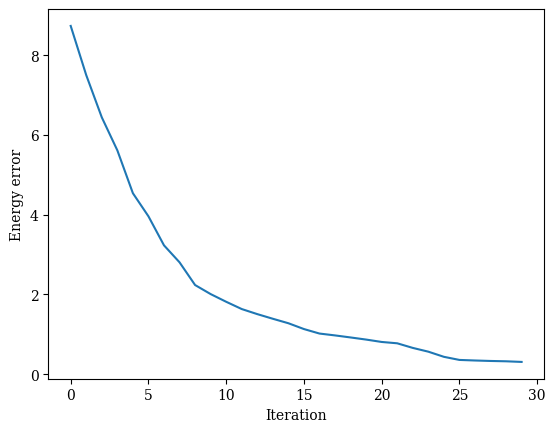

In [88]:
adapt_errors = abs(np.array(adapt_energies) - exact_energy)
fig, ax = plt.subplots()
ax.plot(adapt_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [89]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Get circuit expectation values.

In [90]:
simulator_energies = []
for circuit in circuits:
    sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=adapt_mps_bond)
    estimator = BackendEstimator(backend=sim)
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, sim)
    isa_circuit = pass_manager.run(circuit)
    isa_circuit = RemoveFinalMeasurements()(isa_circuit)
    pub = (isa_circuit, h_qiskit)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    simulator_energies.append(exact_value)

In [91]:
simualtor_errors = np.abs(np.array(simulator_energies) - exact_energy)

Text(0, 0.5, 'Energy error')

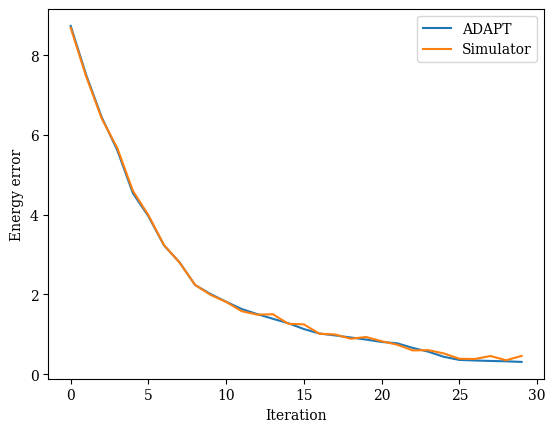

In [92]:
fig, ax = plt.subplots()
ax.plot(adapt_errors, label="ADAPT")
ax.plot(simualtor_errors, label="Simulator")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Carry out SQD.

In [93]:

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [94]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sampler.run([to_run], shots=30_000)
    job = sim.run(to_run)
    # bit_array = job.result()[0].data.meas
    # bit_array = job.result().data().meas
    counts = job.result().data()['counts']
    bit_array = BitArray.from_counts(counts, num_bits=circuit.num_qubits)
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 12, 'x': 5, 'cx': 4, 'rx': 2, 'barrier': 2, 'u2': 1, 'rz': 1, 'h': 1})
On circuit 1/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 12, 'cx': 8, 'x': 5, 'rx': 4, 'h': 3, 'barrier': 3, 'rz': 2, 'u2': 1})
On circuit 2/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 14, 'measure': 12, 'rx': 6, 'x': 5, 'h': 5, 'barrier': 4, 'rz': 3, 'u2': 1})
On circuit 3/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 18, 'measure': 12, 'rx': 8, 'h': 7, 'x': 5, 'barrier': 5, 'rz': 4, 'u2': 1})
On circuit 4/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 24, 'measure': 12, 'rx': 10, 'h': 9, 'barrier': 6, 'x': 5, 'rz': 5, 'u2': 1})
On circuit 5/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 30, 'rx': 12, 'measure': 12, 'h': 11, 'barrier': 7, 'rz': 6, 'x': 5, 'u2': 1})
On circuit 6/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 32, 'rx': 14, 'h': 13, 'measure': 12, 'barrier': 8, 'r

In [95]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

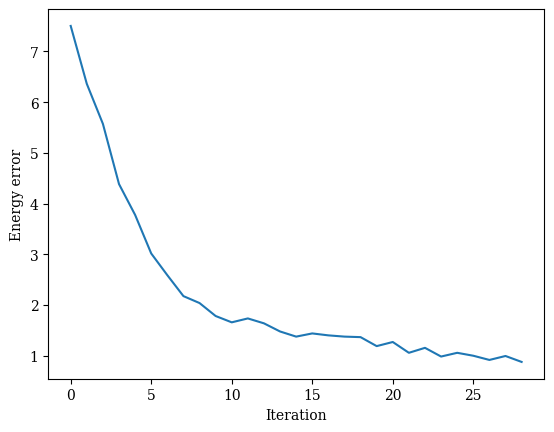

In [96]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [97]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts, num_bits=circuits[0].num_qubits)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

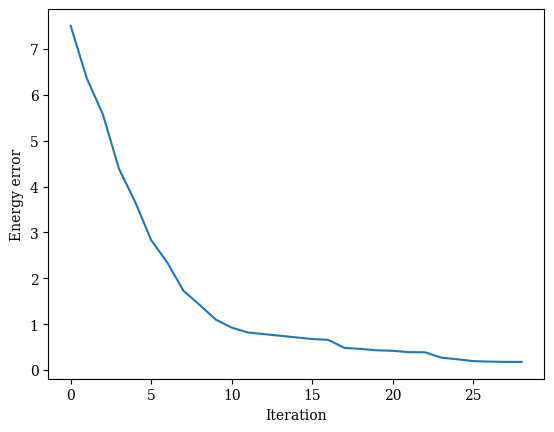

In [98]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

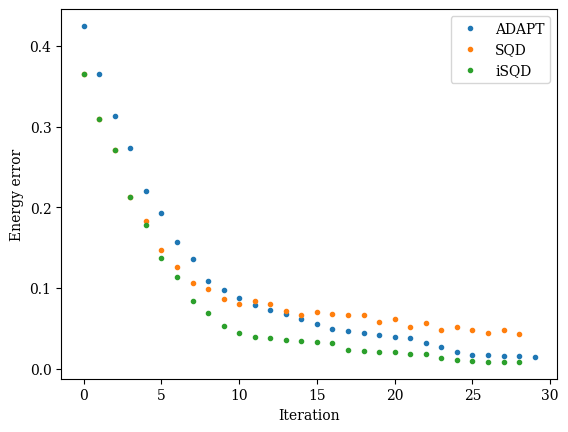

In [99]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="SQD")
ax.plot(stacked_rel_errors, '.', label="iSQD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()